<a href="https://colab.research.google.com/github/ugurtegin/Nonlinear_MMF_Network/blob/main/Unetforfiber.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/pix2pix"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Import TensorFlow and other libraries

In [ ]:
import tensorflow as tf

import os
import time
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
import scipy.io
import h5py
from skimage.transform import resize
import numpy as np




In [ ]:
#!pip install -U tensorboard

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Load the dataset

You can download this dataset and similar datasets from [here](https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets). As mentioned in the [paper](https://arxiv.org/abs/1611.07004) we apply random jittering and mirroring to the training dataset.

* In random jittering, the image is resized to `286 x 286` and then randomly cropped to `256 x 256`
* In random mirroring, the image is randomly flipped horizontally i.e left to right.

In [ ]:
sampCount = 100
BATCH_SIZE = 10
trainCount = 90

In [ ]:
#matInp = scipy.io.loadmat('/content/gdrive/MyDrive/Nonlinear MMF Prop/2020.12.03_AGE/ageinout.mat')
arrays = {}
f = h5py.File('/content/gdrive/MyDrive/datSm.mat')
for k, v in f.items():
    arrays[k] = np.array(v)

outs=arrays['framSm'].astype('float32') 
inps = arrays['diffSm'].astype('float32') 

del arrays


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
outs.shape
inps.shape

(88, 88, 1001)

In [ ]:
# outs=np.rot90(outs[:,:,0:sampCount],-1)
# inps=np.rot90(inps[:,:,0:sampCount],-1)
outs= np.swapaxes(outs,0,2)
inps= np.swapaxes(inps,0,2)

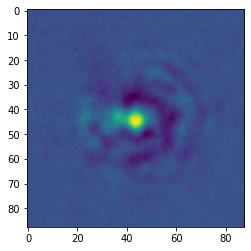

In [ ]:
plt.imshow(inps[2,:,:])

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((inps[0:trainCount,:,:,tf.newaxis], outs[0:trainCount,:,:,tf.newaxis]))
test_dataset = tf.data.Dataset.from_tensor_slices((inps[trainCount:sampCount,:,:,tf.newaxis], outs[trainCount:sampCount,:,:,tf.newaxis]))

In [ ]:
outs.shape

(1001, 20, 15)

In [ ]:
train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Build the Generator
  * The architecture of generator is a modified U-Net.
  * Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)
  * Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)
  * There are skip connections between the encoder and decoder (as in U-Net).


In [ ]:
OUTPUT_CHANNELS = 1

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [ ]:
down_model = downsample(3, 4)
down_result = down_model(inps[tf.newaxis,20,:,:,tf.newaxis])
print (down_result.shape)

(1, 44, 44, 3)


In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 88, 88, 3)


In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256,256,1])

  down_stack = [
    downsample(64, 16, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 16), # (bs, 64, 64, 128)
    downsample(256, 16), # (bs, 32, 32, 256)
    downsample(512, 16), # (bs, 16, 16, 512)
    #downsample(512, 32), # (bs, 8, 8, 512)
    #    downsample(512, 4), # (bs, 4, 4, 512)
    # downsample(512, 4), # (bs, 2, 2, 512)
    # downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    # upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    # upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    # upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    #upsample(512, 32), # (bs, 16, 16, 1024)
    upsample(256, 16), # (bs, 32, 32, 512)
    upsample(128, 16), # (bs, 64, 64, 256)
    upsample(64, 16), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

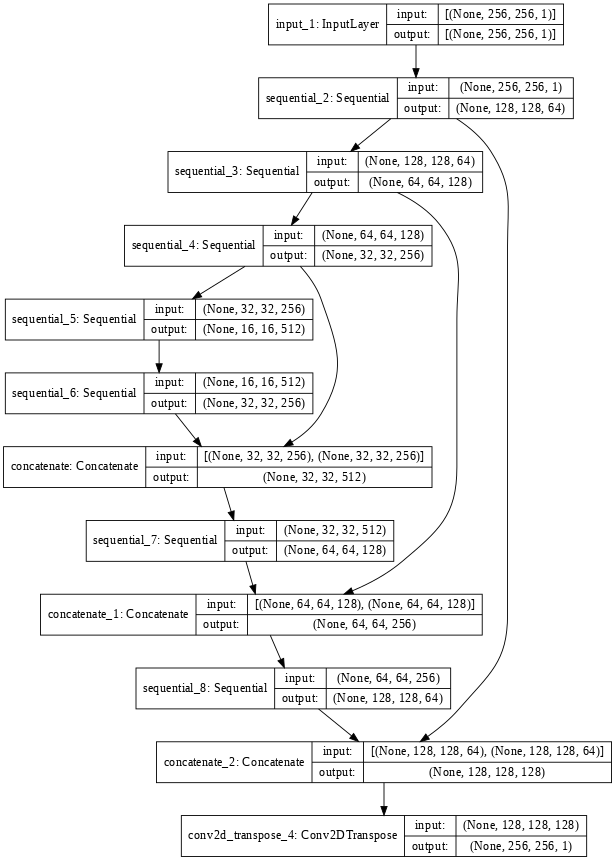

In [ ]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [ ]:
print(generator.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 128, 128, 64) 16384       input_1[0][0]                    
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 64, 64, 128)  2097664     sequential_2[0][0]               
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 32, 32, 256)  8389632     sequential_3[0][0]               
______________________________________________________________________________________________

In [ ]:
gen_output = generator(inps[tf.newaxis,20,:,:,tf.newaxis], training=False)
plt.imshow(np.squeeze(gen_output))

ValueError: ignored

* **Generator loss**
  * It is a sigmoid cross entropy loss of the generated images and an **array of ones**.
  * The [paper](https://arxiv.org/abs/1611.07004) also includes L1 loss which is MAE (mean absolute error) between the generated image and the target image.
  * This allows the generated image to become structurally similar to the target image.
  * The formula to calculate the total generator loss = gan_loss + LAMBDA * l1_loss, where LAMBDA = 100. This value was decided by the authors of the [paper](https://arxiv.org/abs/1611.07004).

The training procedure for the generator is shown below:

In [ ]:
def generator_loss(gen_output, target):

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.math.square(tf.abs(target - gen_output)))


  return  l1_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 generator=generator)                                 

## Generate Images

Write a function to plot some images during training.

* We pass images from the test dataset to the generator.
* The generator will then translate the input image into the output.
* Last step is to plot the predictions and **voila!**

Note: The `training=True` is intentional here since
we want the batch statistics while running the model
on the test dataset. If we use training=False, we will get
the accumulated statistics learned from the training dataset
(which we don't want)

In [ ]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(np.squeeze(display_list[i]))
    plt.axis('off')
  plt.show()


## Training

* For each example input generate an output.
* The discriminator receives the input_image and the generated image as the first input. The second input is the input_image and the target_image.
* Next, we calculate the generator and the discriminator loss.
* Then, we calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
* Then log the losses to TensorBoard.

In [ ]:
EPOCHS = 100

In [ ]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)
    gen_loss = generator_loss(gen_output, target)
    generator_gradients = gen_tape.gradient(gen_loss,
                                          generator.trainable_variables)
  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))


  with summary_writer.as_default():
    tf.summary.scalar('gen_loss', gen_loss, step=epoch)


The actual training loop:

* Iterates over the number of epochs.
* On each epoch it clears the display, and runs `generate_images` to show it's progress.
* On each epoch it iterates over the training dataset, printing a '.' for each example.
* It saves a checkpoint every 20 epochs.

In [ ]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix = checkpoint_prefix)

This training loop saves logs you can easily view in TensorBoard to monitor the training progress. Working locally you would launch a separate tensorboard process. In a notebook, if you want to monitor with TensorBoard it's easiest to launch the viewer before starting the training.

To launch the viewer paste the following into a code-cell:

In [ ]:
#docs_infra: no_execute
%load_ext tensorboard
%tensorboard --logdir {log_dir}

Now run the training loop:

In [ ]:
test_dataset

In [ ]:
fit(train_dataset, EPOCHS, test_dataset)

If you want to share the TensorBoard results _publicly_ you can upload the logs to [TensorBoard.dev](https://tensorboard.dev/) by copying the following into a code-cell.

Note: This requires a Google account.

```
!tensorboard dev upload --logdir  {log_dir}
```

Caution: This command does not terminate. It's designed to continuously upload the results of long-running experiments. Once your data is uploaded you need to stop it using the "interrupt execution" option in your notebook tool.

You can view the [results of a previous run](https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw) of this notebook on [TensorBoard.dev](https://tensorboard.dev/).

TensorBoard.dev is a managed experience for hosting, tracking, and sharing ML experiments with everyone.

It can also included inline using an `<iframe>`:

In [ ]:
display.IFrame(
    src="https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw",
    width="100%",
    height="1000px")

Interpreting the logs from a GAN is more subtle than a simple classification or regression model. Things to look for::

* Check that neither model has "won". If either the `gen_gan_loss` or the `disc_loss` gets very low it's an indicator that this model is dominating the other, and you are not successfully training the combined model.
* The value `log(2) = 0.69` is a good reference point for these losses, as it indicates a perplexity of 2: That the discriminator is on average equally uncertain about the two options.
* For the `disc_loss` a value below `0.69` means the discriminator is doing better than random, on the combined set of real+generated images.
* For the `gen_gan_loss` a value below `0.69` means the generator i doing better than random at foolding the descriminator.
* As training progresses the `gen_l1_loss` should go down.

## Restore the latest checkpoint and test

In [ ]:
!ls {checkpoint_dir}

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Generate using test dataset

In [ ]:
# Run the trained model on a few examples from the test dataset
for inp, tar in train_dataset.take(5):
  generate_images(generator, inp, tar)

In [ ]:
prediction = generator(inps[tf.newaxis,98,:,:,tf.newaxis], training=False)

In [ ]:
plt.imshow(np.squeeze(prediction))

In [ ]:
plt.imshow(np.squeeze(outs[tf.newaxis,98,:,:,tf.newaxis]))

In [ ]:
plt.imshow(np.squeeze(inps[tf.newaxis,98,:,:,tf.newaxis]))

In [ ]:
wghts=generator.get_weights()

In [ ]:
size = 1
for dim in np.shape(wghts): size *= dim

In [ ]:
wghts[0].shape